In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [2]:
class Arm:
    def __init__(self, alphas, betas):
        self.num_attributes = len(alphas)        #Number of attributes
        self.alphas = alphas                            #List of means of each attribute
        self.betas = betas                      #List of standard deviations
        self.mu_hat = np.zeros(self.num_attributes) #List of empirical means
        self.times_pulled = 0                       #Number of times the arm is pulled

    def pull(self):
        reward = []
        for att in range(self.num_attributes):
            alpha, beta = self.alphas[att], self.betas[att]
            reward.append(np.random.beta(alpha, beta, 1)[0])
        self.mu_hat = ((self.mu_hat * self.times_pulled) + reward) / (self.times_pulled + 1)
        self.times_pulled += 1
        return reward                               #List of reward from each attribute

    def hoeffding(self, delta):
        return np.exp(-2*(delta**2)*(self.times_pulled))
    
    def lcb(self, delta = 0.2):
        return self.mu_hat - self.hoeffding(delta)    #List of LCBs for each attribute
    
    def ucb(self, delta = 0.2):
        return self.mu_hat + self.hoeffding(delta)    #List of UCBs for each attribute
    
    def arm_lcb(self, delta = 0.2):
        return sum(self.mu_hat) - self.hoeffding(delta)    #LCB for the arm
    
    def arm_ucb(self, delta = 0.2):
        return sum(self.mu_hat) + self.hoeffding(delta)    #UCB for the arm
    
    def reset(self):
        self.mu_hat = np.zeros(self.num_attributes)
        self.times_pulled = 0

In [3]:
class Action_Elimination:
    #Arm_params is of the form [(alpha1, beta1), (alpha2, beta2), ...]. Each aplphai and betai is an array.
    def __init__(self, arm_params, uniform_exp = 10, delta = 0.1, threshold = 0.2):
        self.arms = [Arm(params[0], params[1]) for params in arm_params]
        self.num_arms = len(self.arms)
        #All the arms should have the same number of attributes
        self.num_attributes = self.arms[0].num_attributes
        self.uniform_exp = uniform_exp
        self.delta = delta
        self.threshold = threshold

    def start(self):
        for arm in self.arms:
            arm.reset()
        omega_curr = list(range(self.num_arms))
        while len(omega_curr) > 1:
            for arm_index in omega_curr:
                for _ in range(self.uniform_exp):    
                    self.arms[arm_index].pull()                                                 #Uniform exploration
                # print(self.arms[arm_index].lcb(), self.arms[arm_index].mu_hat, self.arms[arm_index].ucb())
                # print(self.arms[arm_index].arm_lcb(), self.arms[arm_index].arm_ucb())

            ref_arm_index = max(omega_curr, key = lambda index: np.max(self.arms[index].ucb())) #Reference arm
            # print(ref_arm_index)

            omega_next = []
            for arm_index in omega_curr:
                if min((self.arms[arm_index]).ucb()) >= self.threshold:                        #Threshold condition
                    if self.arms[ref_arm_index].arm_lcb() <= self.arms[arm_index].arm_ucb():   #Mean condition
                        omega_next.append(arm_index)
            if len(omega_next) == 0:
                for arm_index in omega_curr:
                    if min((self.arms[arm_index]).ucb()) >= self.threshold:
                        omega_next.append(arm_index)
            omega_curr = omega_next
            # print(omega_curr)

        if len(omega_curr) > 0:
            return omega_curr[0]
        else:
            return -1  

# Single Instance

## Base Case: 5 Arms

In [55]:
arms_params = np.array([([1, 1], [0.11, 9]),        #0.9, 0.1
                        ([1, 1], [9, 2.33]),        #0.1, 0.3    
                        ([1, 1], [4, 1.5]),         #0.2, 0.4
                        ([1, 1], [1.5, 1.5]),       #0.4, 0.4
                        ([1, 1], [1, 9])])          #0.5, 0.1

N_iter = 1000
count = [0 for _ in range (len(arms_params) + 1)]
for i in range (N_iter):
    # print(i)
    ae = Action_Elimination(arms_params)
    best_arm = ae.start()
    # print(best_arm)
    count[best_arm] += 1

count = np.array(count)  
print(count/N_iter)

[0.18  0.    0.005 0.814 0.    0.001]


## Multiple Instances

#### Case 1A

In [56]:
N_iter = 100
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [(1/x) - 1, 0.66]),    #x, 0.6   - best arm
                        ([1, 1], [1, 0.66]),                #0.5, 0.6
                        ([1, 1], [4, 0.25]),                #0.2, 0.8
                        ([1, 1], [1.5, 1]),                 #0.4, 0.5
                        ([1, 1], [1, 2.33])])               #0.5, 0.3
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.3)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


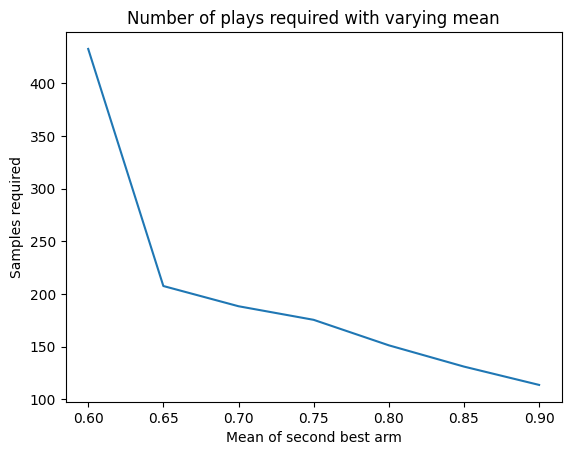

In [6]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [57]:
print(prob_success)

[0.9, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Case 1B

In [58]:
N_iter = 100
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [(1/x) - 1, 0.01]),   #x, 0.6   - best arm
                        ([1, 1.5], [1, 1.5]),              #0.5, 0.6
                        ([1, 4], [4, 1.5]),                #0.2, 0.8
                        ([1, 1], [9, 1]),                  #0.4, 0.5
                        ([1, 1], [1, 2.33])])              #0.5, 0.3
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.3)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


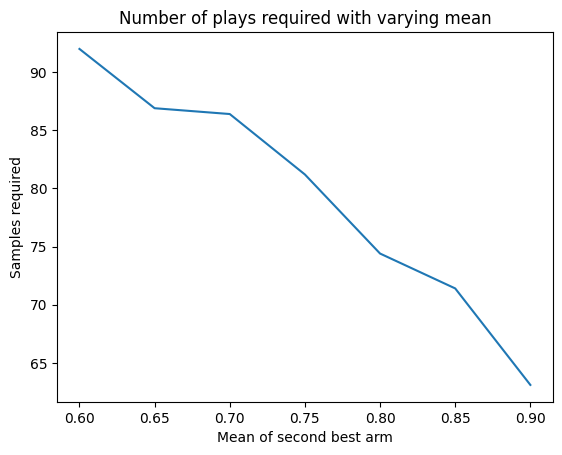

In [149]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [59]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Case 2

In [53]:
N_iter = 50
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [(1/x) - 1, 0.25]),    #x, 0.6
                        ([1, 1], [2.33, 0.01]),                #0.5, 0.6
                        ([1, 1], [1, 0.67]),                #0.2, 0.8
                        ([1, 1], [1.5, 1]),                 #0.4, 0.5
                        ([1, 1], [9, 1])])               #0.5, 0.3
    count = [0 for _ in range (len(arms_params) + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.4)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


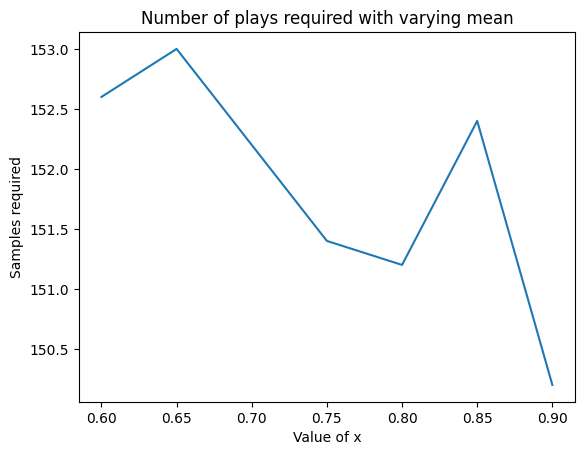

In [54]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 3

In [62]:
N_iter = 100
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [0.82, 0.67]),    #x, 0.6
                        ([1, 1], [1.5, 0.67]),         #0.5, 0.6
                        ([1, 1], [1/x - 1, 0.01]),     #0.2, 0.8 - best arm
                        ([1, 1], [1.5, 1]),            #0.4, 0.5
                        ([1, 1], [9, 1])])             #0.5, 0.3
    count = [0 for _ in range (ae.num_arms + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.5)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[2]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


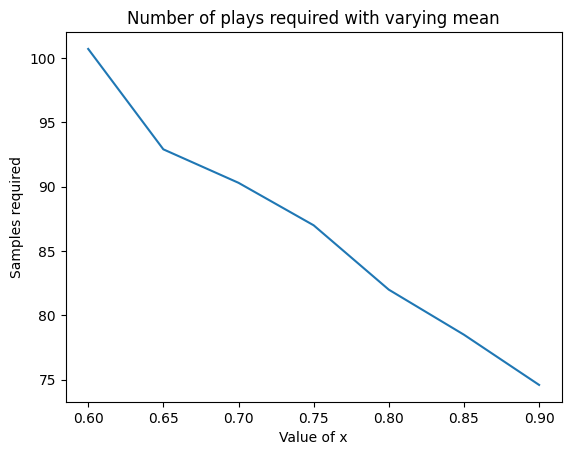

In [48]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

In [63]:
print(prob_success)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


#### Case 4A

In [49]:
N_iter = 50
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [0.25, 1/x - 1]),    #x, 0.6
                        ([1, 1], [2.33, 1]),                #0.5, 0.6
                        ([1, 1], [1.5, 0.67]),                #0.2, 0.8
                        ([1, 1], [0.25, 1]),                 #0.4, 0.5
                        ([1, 1], [4, 1.5])])               #0.5, 0.3
    count = [0 for _ in range (ae.num_arms + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.4)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


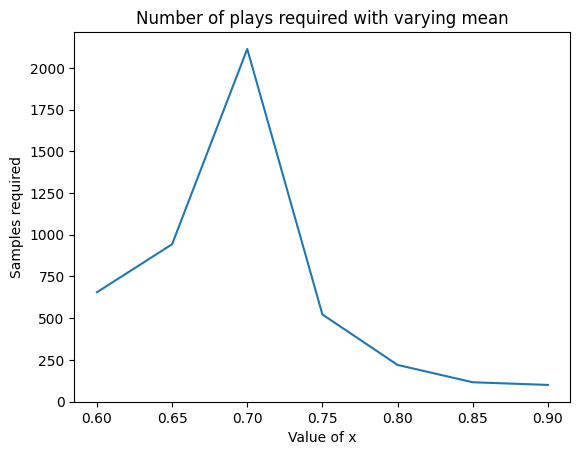

In [50]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

#### Case 4B

In [51]:
N_iter = 100
samples_ins = []
x_val = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    arms_params = np.array([([1, 1], [1, 0.43]),    #x, 0.6
                        ([1, 1], [1/x - 1, 0.25]),                #0.5, 0.6
                        ([1, 1], [2.33, 1]),                #0.2, 0.8
                        ([1, 1], [1, 1]),                 #0.4, 0.5
                        ([1, 1], [4, 1.5])])               #0.5, 0.3
    count = [0 for _ in range (ae.num_arms + 1)]
    samples_all = []
    for i in range (N_iter):
        ae = Action_Elimination(arms_params, threshold = 0.4)
        best_arm_guess = ae.start()
        samples_all.append(sum([arm.times_pulled for arm in ae.arms]))
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    prob_success.append(count[0]/N_iter)
    print("Done")

Done
Done
Done
Done
Done
Done
Done


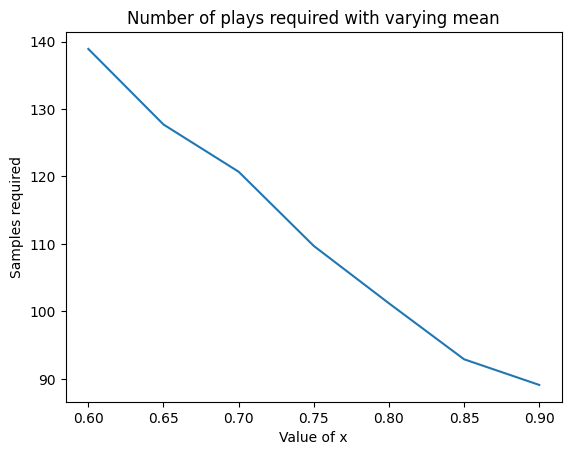

In [52]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Value of x")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()